<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Lab_5/Taller/Laboratorio_V_Taller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021




## Integrantes

*   Integrante 1: Daniel Mateo Guatibonza Solano - 201611360
*   Integrante 2: Raquel Andrea Cerda Montañez - 201533520
*   Integrante 3: Sergio Eduardo Cárdenas Landazabal - 201613444



## **Problema 1**

- En la Universidad de Caltech, se creó un dataset de aves cuyos datos se encuentran en formato TFRecord y almacenan la etiqueta de la especie del ave junto con los datos de detección de la misma. El formato de detección del ave es la coordenada en X e Y de la esquina superior izquierda, el ancho y el largo del cuadro. Su deber es clasificar las 200 especies haciendo uso de redes neuronales convolucionales. Además, como punto extra, ud deberá clasificar y detectar al mismo tiempo a través de una red bimodal o de salida doble. Los datos se ven de la siguiente forma:

![image](https://docs.google.com/uc?export=download&id=1Qg9UTiKOEapYRyBt5nRjikZjs-RuNl_k)

Pueden hacer uso del siguiente [recurso](https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/extras/practica_tfrecord.ipynb) para guiarse.

- [Data de entrenamiento](https://drive.google.com/file/d/1shoNNn7PuTB-Hv46RV1Hv8E4W4umDWII/view?usp=sharing)
- [Data de Validación](https://drive.google.com/file/d/16MlEZxvNvuoek7IIDvs-JHxaKLE3OiZb/view?usp=sharing)
- [Data de Testing](https://drive.google.com/file/d/1E0A0Ve4vBEyOZAw9f0f5f__uAgyvQvsa/view?usp=sharing)

# Desarrollo
Para el presente laboratorio se optó por hacer uso de la infraestructura de Colab provista por Google dado que, para lograr unos tiempos de entrenamiento dentro del plazo estipulado, se requería una GPU como acelerador de hardware para el procesamiento.

## Librerías necesarias
En primera instancia, se instala la librería *tensorflow_addons* que implementa la función de pérdida asociada a la detección de *bounding boxes*.

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


De forma seguida, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción de los modelos incluyendo las librerías requeridas para la selección de hiperparámetros y la librería recién instalada.

In [61]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import os
from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import tensorflow_addons.losses.giou_loss as GIoU_Loss

from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import cv2

import re

from typing import Optional, Union, List, Tuple, ByteString, Dict

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import files

## Lectura de datos
Para acceder desde el notebook a los datos almacenados en forma de TFRecord, fue necesario autenticarse en Google ya que tales archivos fueron cargados en GoogleDrive:

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Luego, se traen dichos archivos al entorno de ejecución actual a partir del identificador otorgado por GoogleDrive y se cargan por medio de la función *TFRecordDataset*.

In [6]:
train_file = drive.CreateFile({'id':"1qQ7VGJYxRXehXJSNUZzscF1d3fNglpG-"})
train_file.GetContentFile('train.tfrec') 

val_file = drive.CreateFile({'id':"1F7njYmpDbTBbYB52N0p3GBDuvO4ZXaWp"})
val_file.GetContentFile('val.tfrec') 

test_file = drive.CreateFile({'id':"1fMs0bc0UpnO-0aoSibNi4ePU-zqLgDYl"})
test_file.GetContentFile('test.tfrec') 

In [23]:
train_dataset = tf.data.TFRecordDataset("/content/train.tfrec")
val_dataset = tf.data.TFRecordDataset("/content/val.tfrec")
test_dataset = tf.data.TFRecordDataset("/content/test.tfrec")

## Preparación de los datos
Una vez se tiene el acceso a los tres datasets de interés, se definen tres funciones auxiliares que permitan:
1. Segmentar los datos contenidos en el TFRecord en la imagen, la etiqueta y el *bounding box*. Adicionalmente, dado que se pretende construir una red bimodal, los dos últimos se almacenan en un mismo diccionario que representa la salida. 
2. Ajustar el tamaño de las imágenes en formato RGB así como las dimensones del *bounding box*.
3. Visualizar un conjunto de imágenes de forma tabular con su respectivo título.

In [4]:
@tf.function
def parse_image_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
        "bbox": tf.io.FixedLenFeature([4], tf.int64),
    }

    feature = tf.io.parse_single_example(
        example_input, image_feature_description,
    )

    image = feature["image"]
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32) / 255.

    label = tf.cast(feature["class"], tf.int32)
    bbox = tf.cast(feature["bbox"], tf.float32)

    return image, {'label': label, 'bbox': bbox}

@tf.function
def process_image(image: Optional[tf.Tensor], output: Optional[Dict[str,tf.Tensor]],) -> Optional[Tuple[tf.Tensor]]:
    shape = tf.shape(image)
    image = tf.image.resize(image, (224, 224))
    image = tf.cond(shape[2]==tf.constant(1), lambda: tf.image.grayscale_to_rgb(image), lambda: image)

    label = output['label']
    bbox = output['bbox']

    x_scale = 224. / tf.cast(shape[1], tf.float32)
    y_scale = 224. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(bbox[0] * x_scale),
            tf.round(bbox[1] * y_scale),
            tf.round((bbox[0] + bbox[2]) * x_scale),
            tf.round((bbox[1] + bbox[3]) * y_scale),]

    return image, {'label': label, 'bbox': bbox}

def visualize_subplot(imgs: List[np.ndarray], titles: List[str], division: Tuple[int], figsize: Tuple[int] = None, cmap: str = "gray"):
    fig: plt.Figure = plt.figure(figsize=figsize)
    if figsize:
        fig.set_figwidth(figsize[0])
        fig.set_figheight(figsize[1])

    assert len(imgs) == len(titles), "La lista de imágenes y de títulos debe ser del mismo tamaño"
    assert np.prod(division) >= len(imgs)

    for index, title in enumerate(titles):
        ax: plt.Axes = fig.add_subplot(division[0], 
                            division[1], index+1)
        ax.imshow(imgs[index], cmap=cmap)
        ax.set_title(title)
        plt.axis("off")

In [24]:
train_dataset = train_dataset.map(parse_image_function)
train_dataset = train_dataset.map(process_image)

val_dataset = val_dataset.map(parse_image_function)
val_dataset = val_dataset.map(process_image)

test_dataset = test_dataset.map(parse_image_function)
test_dataset = test_dataset.map(process_image)

Después de haber procesado los datos, se comprueba la correcta transformación al ilustrar cuatro de los pájaros con su etiqueta numérica y el *bounding box* que lo demarca.

In [ ]:
imgs = []
labels = []
for img, out in train_dataset.take(4):
    label, bbox = out['label'], out['bbox']
    new_img = cv2.rectangle(img.numpy(), (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (1, 0, 0), 3)
    imgs.append(new_img)
    labels.append(label.numpy())

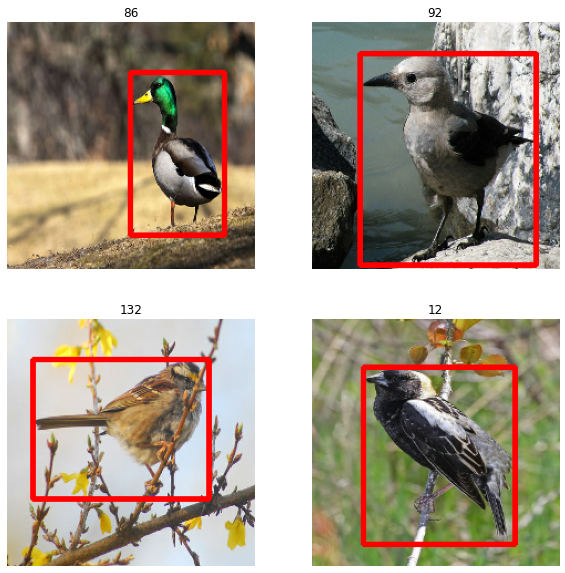

In [ ]:
visualize_subplot(imgs, labels, (2, 2), (10, 10),)

### Exploración y descripción de los datos

Con el propósito de conocer la distribución de los datos, se hace un conteo por categoría sobre el conjunto de entrenamiento y se hace una gráfica de dicha distribución; como se puede observar, esta es aproximadamente uniforme.

In [ ]:
dict_labels = {}
for img, out in train_dataset.take(8000):
    label, bbox = out['label'], out['bbox']
    if label.numpy() in dict_labels.keys():
        dict_labels[label.numpy()] += 1
    else:
        dict_labels[label.numpy()] = 1 

Número de categorías: 200
Número total de datos: 7544


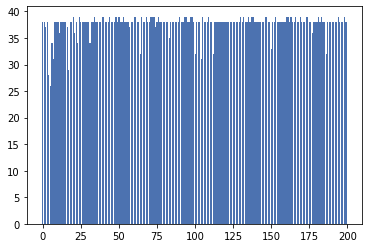

In [ ]:
plt.bar(dict_labels.keys(), dict_labels.values())
print('Número de categorías:', len(dict_labels.keys()))
print('Número total de datos:', sum(dict_labels.values()))

Posteriormente, se valida el tamaño de los conjuntos de validación y prueba así como el tamaño de las imágenes con el fin de declarar constantes auxiliares que se usarán más adelante. Cabe aclarar que se define también un tamaño de batch de 64 datos.

In [ ]:
train_dataset.cardinality

<bound method DatasetV2.cardinality of <MapDataset shapes: ((224, 224, None), {label: (), bbox: (4,)}), types: (tf.float32, {label: tf.int32, bbox: tf.float32})>>

In [25]:
contador = 0
for img, out in val_dataset.take(8000):
    contador += 1
print("Datos de validación:", contador)
contador = 0
for img, out in test_dataset.take(8000):
    contador += 1
print("Datos de prueba:", contador)

Datos de validación: 1886
Datos de prueba: 2358


In [26]:
BATCH_SIZE = 64
TRAIN_SIZE = 7544
VAL_SIZE = 1886
TEST_SIZE = 2358
SIZE = (224, 224)

Ahora bien, para la implementación del clasificador, se opta por una codificación binaria de la variable a predecir (*one hot encoding*) para lo cual se implementan las siguientes funciones. 

In [27]:
classes = list(range(200))
def get_label(label: Optional[tf.Tensor]) -> tf.Tensor:
    one_hot = label == classes
    return tf.convert_to_tensor(one_hot)

In [28]:
@tf.function
def process_label(image: Optional[tf.Tensor], output: Optional[Dict[str,tf.Tensor]],) -> Optional[Tuple[tf.Tensor]]:
    label, bbox = output['label'], output['bbox']
    label = get_label(label)
    return image, {'label': label, 'bbox': bbox}

In [29]:
train_dataset = train_dataset.map(process_label)
val_dataset = val_dataset.map(process_label)
test_dataset = test_dataset.map(process_label)

Finalmente, se utiliza una función que permita realizar las particiones en batches y que se repita el dataset a medida que se itera sobre él. Lo anterior también considerando los casos en los que algunos datos pueden quedar por fuera de los batches. Adicionalmente, sobre el conjunto de entrenamiento se define que este sea reordenado después de cada iteración de forma que el orden no influya en el proceso de aprendizaje.

In [30]:
def performance(dataset: Optional[tf.data.Dataset], train: bool = True,) -> Optional[tf.data.Dataset]:
    if train:
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [31]:
train_dataset = performance(train_dataset)
val_dataset = performance(val_dataset, False)
test_dataset = performance(test_dataset, False)

## Modelado

Inicialmente se plantea un modelo base a partir de la red de InceptionV3 cuya salida es promediada entre canales y sirve como entrada de la red bimodal que consta de un clasificador y un regresor. En ambos casos, se opta por utilizar dos capas intermedias con activación *relu* como se muestra enseguida. Es importante notar que las capas de la red de InceptionV3 son congeladas de forma que sus pesos no se vean alterados durante el entrenamiento.

In [ ]:
base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet", 
    input_shape=(*SIZE, 3),
)

global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1_1 = keras.layers.Dense(128, activation = 'relu')(global_avg)
dense_1_2 = keras.layers.Dense(32, activation = 'relu')(dense_1_1)
output_clas = keras.layers.Dense(200, activation = 'softmax', name = 'label')(dense_1_2)

dense_2_1 = keras.layers.Dense(64, activation = 'relu')(global_avg)
dense_2_2 = keras.layers.Dense(16, activation = 'relu')(dense_2_1)
output_loc = keras.layers.Dense(4, name = 'bbox')(dense_2_2)


model = keras.Model(inputs = base_model.inputs, outputs = [output_clas, output_loc])

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Posterior a ello, se define un criterio de parada del entrenamiento como un callback que realiza esto en caso de que entre 3 épocas no haya una disminución en la función de costo. Luego, se compila el modelo especificando el tipo de función de costo a minimizar para cada red y el optimizador Adam. En el caso del clasificador se utilizará la función de entropía cruzada mientras que para la predicción de los *bounding boxes* se hará uso de una función de pérdida basada en el criterio de la intersección sobre la unión.

In [15]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer = optimizer, loss = {'bbox':GIoU_Loss, 'label':'categorical_crossentropy'},
    metrics = {'label':'acc'},
)

Después de compilar el modelo, este es entrenado al especificar el dataset dispuesto para esta etapa. En suma a ello, se especifica un aprendizaje de 250 pasadas sobre los datos (épocas). Así también, se guarda el modelo obtenido en un archivo de extensión H5 para poder hacer uso del mismo en pasos posteriores.

In [ ]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 250,
    "validation_data": val_dataset,
    "verbose": 1,
    "callbacks": callbacks
}
history = model.fit(train_dataset, **params)

Epoch 1/250
117/117 [==============================] - 264s 2s/step - loss: 6.6281 - label_loss: 5.2554 - bbox_loss: 1.3727 - label_acc: 0.0073 - val_loss: 6.3866 - val_label_loss: 5.1641 - val_bbox_loss: 1.2225 - val_label_acc: 0.0119
Epoch 2/250
117/117 [==============================] - 261s 2s/step - loss: 6.1537 - label_loss: 5.0599 - bbox_loss: 1.0938 - label_acc: 0.0282 - val_loss: 5.9615 - val_label_loss: 4.9364 - val_bbox_loss: 1.0251 - val_label_acc: 0.0372
Epoch 3/250
117/117 [==============================] - 261s 2s/step - loss: 5.8054 - label_loss: 4.7912 - bbox_loss: 1.0142 - label_acc: 0.0598 - val_loss: 5.6673 - val_label_loss: 4.6599 - val_bbox_loss: 1.0074 - val_label_acc: 0.0797
Epoch 4/250
117/117 [==============================] - 263s 2s/step - loss: 5.4815 - label_loss: 4.4762 - bbox_loss: 1.0053 - label_acc: 0.1019 - val_loss: 5.3543 - val_label_loss: 4.3504 - val_bbox_loss: 1.0038 - val_label_acc: 0.1218
Epoch 5/250
117/117 [==============================] - 2

Epoch 36/250
117/117 [==============================] - 266s 2s/step - loss: 2.5661 - label_loss: 1.5661 - bbox_loss: 1.0000 - label_acc: 0.6027 - val_loss: 3.2328 - val_label_loss: 2.2328 - val_bbox_loss: 1.0000 - val_label_acc: 0.4240
Epoch 37/250
117/117 [==============================] - 265s 2s/step - loss: 2.5428 - label_loss: 1.5428 - bbox_loss: 1.0000 - label_acc: 0.6170 - val_loss: 3.2213 - val_label_loss: 2.2213 - val_bbox_loss: 1.0000 - val_label_acc: 0.4273
Epoch 38/250
117/117 [==============================] - 264s 2s/step - loss: 2.5222 - label_loss: 1.5222 - bbox_loss: 1.0000 - label_acc: 0.6233 - val_loss: 3.2113 - val_label_loss: 2.2113 - val_bbox_loss: 1.0000 - val_label_acc: 0.4343
Epoch 39/250
117/117 [==============================] - 264s 2s/step - loss: 2.5030 - label_loss: 1.5030 - bbox_loss: 1.0000 - label_acc: 0.6219 - val_loss: 3.1936 - val_label_loss: 2.1936 - val_bbox_loss: 1.0000 - val_label_acc: 0.4386
Epoch 40/250
117/117 [==============================

Epoch 105/250
117/117 [==============================] - 264s 2s/step - loss: 1.6003 - label_loss: 0.6003 - bbox_loss: 1.0000 - label_acc: 0.8758 - val_loss: 3.1732 - val_label_loss: 2.1732 - val_bbox_loss: 1.0000 - val_label_acc: 0.4833
Epoch 106/250
117/117 [==============================] - 265s 2s/step - loss: 1.5931 - label_loss: 0.5931 - bbox_loss: 1.0000 - label_acc: 0.8791 - val_loss: 3.1693 - val_label_loss: 2.1693 - val_bbox_loss: 1.0000 - val_label_acc: 0.4849
Epoch 107/250
117/117 [==============================] - 264s 2s/step - loss: 1.5824 - label_loss: 0.5824 - bbox_loss: 1.0000 - label_acc: 0.8831 - val_loss: 3.1773 - val_label_loss: 2.1773 - val_bbox_loss: 1.0000 - val_label_acc: 0.4898
Epoch 108/250
117/117 [==============================] - 265s 2s/step - loss: 1.5791 - label_loss: 0.5791 - bbox_loss: 1.0000 - label_acc: 0.8831 - val_loss: 3.1733 - val_label_loss: 2.1733 - val_bbox_loss: 1.0000 - val_label_acc: 0.4838
Epoch 109/250
117/117 [=========================

117/117 [==============================] - 266s 2s/step - loss: 1.1985 - label_loss: 0.1985 - bbox_loss: 1.0000 - label_acc: 0.9812 - val_loss: 3.5588 - val_label_loss: 2.5588 - val_bbox_loss: 1.0000 - val_label_acc: 0.4806
Epoch 174/250
117/117 [==============================] - 266s 2s/step - loss: 1.1919 - label_loss: 0.1919 - bbox_loss: 1.0000 - label_acc: 0.9829 - val_loss: 3.5725 - val_label_loss: 2.5725 - val_bbox_loss: 1.0000 - val_label_acc: 0.4795
Epoch 175/250
117/117 [==============================] - 266s 2s/step - loss: 1.1895 - label_loss: 0.1895 - bbox_loss: 1.0000 - label_acc: 0.9834 - val_loss: 3.5786 - val_label_loss: 2.5786 - val_bbox_loss: 1.0000 - val_label_acc: 0.4795
Epoch 176/250
117/117 [==============================] - 264s 2s/step - loss: 1.1845 - label_loss: 0.1845 - bbox_loss: 1.0000 - label_acc: 0.9828 - val_loss: 3.5774 - val_label_loss: 2.5774 - val_bbox_loss: 1.0000 - val_label_acc: 0.4817
Epoch 177/250
117/117 [==============================] - 268s 

117/117 [==============================] - 267s 2s/step - loss: 1.0397 - label_loss: 0.0397 - bbox_loss: 1.0000 - label_acc: 1.0000 - val_loss: 4.2306 - val_label_loss: 3.2306 - val_bbox_loss: 1.0000 - val_label_acc: 0.4741
Epoch 242/250
117/117 [==============================] - 267s 2s/step - loss: 1.0388 - label_loss: 0.0388 - bbox_loss: 1.0000 - label_acc: 1.0000 - val_loss: 4.2585 - val_label_loss: 3.2585 - val_bbox_loss: 1.0000 - val_label_acc: 0.4779
Epoch 243/250
117/117 [==============================] - 266s 2s/step - loss: 1.0374 - label_loss: 0.0374 - bbox_loss: 1.0000 - label_acc: 1.0000 - val_loss: 4.2481 - val_label_loss: 3.2481 - val_bbox_loss: 1.0000 - val_label_acc: 0.4790
Epoch 244/250
117/117 [==============================] - 266s 2s/step - loss: 1.0366 - label_loss: 0.0366 - bbox_loss: 1.0000 - label_acc: 1.0000 - val_loss: 4.2562 - val_label_loss: 3.2562 - val_bbox_loss: 1.0000 - val_label_acc: 0.4752
Epoch 245/250
117/117 [==============================] - 266s 

In [ ]:
model.save('/content/modelo_base.h5')

Una vez concluido el entrenamiento, se grafican la función de costo para las dos tareas así como la exactitud en el caso del clasificador. Por un lado, la función de costo del clasificador evidencia un claro sobreajuste de los datos por parte del modelo ya que aproximadamente a partir de la época 50 la función de costo en validación tuvo un comportamiento creciente a diferencia del caso con los datos de entrenamiento. Esto se ve reflejado también en la gráfica de exactitud, ya que en los datos de entrenamiento esta métrica se acerca al 100% a medida del paso de las épocas mientras que se tiende a saturar para el caso de validación. Por otro lado, la subred de regresión se ve estancada desde épocas iniciales en un valor de 1 para la función de pérdida lo que implica que no es capaz de mejorar su desempeño a partir de este punto.

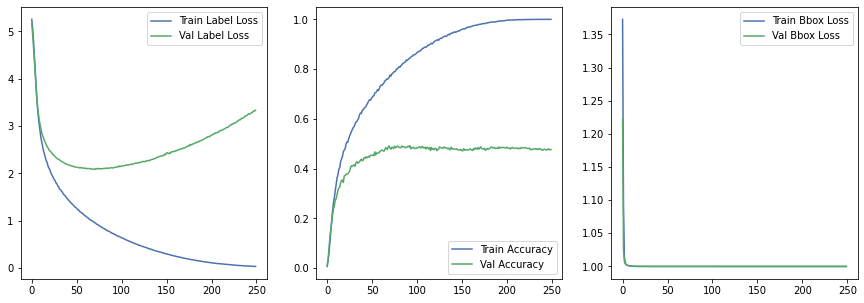

<Figure size 1200x480 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.figure(figsize=(15, 6), dpi=80)
ax1.plot(history.history['label_loss'])
ax1.plot(history.history['val_label_loss'])
ax1.legend(['Train Label Loss', 'Val Label Loss'])
ax2.plot(history.history['label_acc'])
ax2.plot(history.history['val_label_acc'])
ax2.legend(['Train Accuracy', 'Val Accuracy'])
ax3.plot(history.history['bbox_loss'])
ax3.plot(history.history['val_bbox_loss'])
ax3.legend(['Train Bbox Loss', 'Val Bbox Loss'])

No obstante, se procede a visualizar los *bounding boxes* que predice el modelo con el fin de validar que tanto se aproximan a los bordes reales. Tal como se observa, el aprendizaje alcanzado logra detectar en qué zona se encuentra el cuerpo del pájaro aunque de forma muy inexacta.

In [ ]:
for X_batch, y_batch in val_dataset.take(1):
    break
np.random.seed(0)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_labels = np.where(y_batch['label'].numpy() == True)[1][random_sample]
y_bboxs = y_batch['bbox'].numpy()[random_sample]
y_pred = model.predict(X_img)
y_pred_labels = y_pred[0].argmax(axis=1)
y_pred_bboxs = y_pred[1]

In [ ]:
imgs = []
labels = []
for img, label, bbox, pred_label, pred_bbox in zip(X_img, y_labels, y_bboxs, y_pred_labels, y_pred_bboxs):
    new_img = cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (1, 0, 0), 3)
    new_img = cv2.rectangle(img, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 0, 1), 3)
    imgs.append(new_img)
    labels.append("Label: " + str(label) + "; Pred Label: " + str(pred_label))

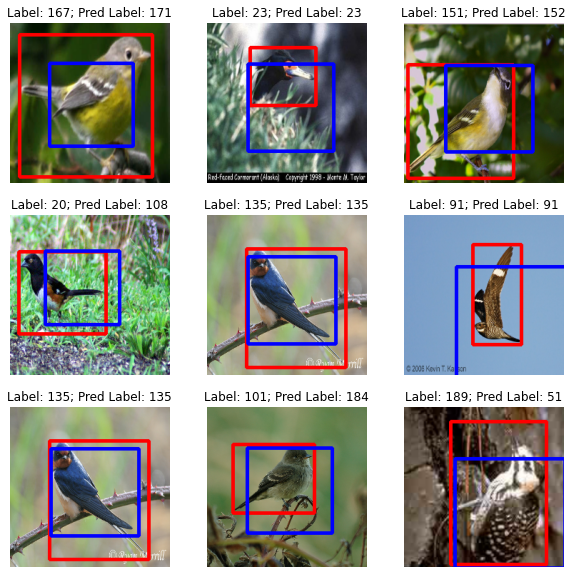

In [ ]:
visualize_subplot(imgs, labels, (3, 3), (10, 10),)

De esta forma, se estructura una función que permitirá modificar los hiperparámetros de la red bimodal. Dado que se observó un sobreajuste al utilizar dos capas intermedias, esta función considera únicamente la utilización de una o ninguna de estas capas para las dos subredes.

In [ ]:
def crear_red_bimodal(nn_lab=0, nn_bb=0, activacion_oculta='relu'):
    base_model = keras.applications.InceptionV3(
        include_top=False,
        weights="imagenet", 
        input_shape=(*SIZE, 3),
    )

    global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    output_clas = None
    if nn_lab != 0:
        dense_1 = keras.layers.Dense(nn_lab, activation=activacion_oculta)(global_avg)
        output_clas = keras.layers.Dense(200, activation = 'softmax', name = 'label')(dense_1)
    else:
        output_clas = keras.layers.Dense(200, activation = 'softmax', name = 'label')(global_avg)
    
    output_loc = None
    if nn_bb != 0:
        dense_2 = keras.layers.Dense(nn_bb, activation=activacion_oculta)(global_avg)
        output_loc = keras.layers.Dense(4, name = 'bbox')(dense_2)
    else:
        output_loc = keras.layers.Dense(4, name = 'bbox')(global_avg)        
    
    model = keras.Model(inputs = base_model.inputs, outputs = [output_clas, output_loc])
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), 
                    loss = {'bbox':GIoU_Loss, 'label':'categorical_crossentropy'},
                    metrics = {'label':'acc'},)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

En esta ocasión, no es factible valerse de librerías como *RandomizedSearchCV* de sklearn dada su incompatibilidad con los datasets de tensorflow. Por lo tanto, se itera sobre valores de los hiperparámetros de forma manual. En adición, se consideró el hecho de que los parámetros entrenables entre las dos subredes son independientes entre sí ya que la parte compartida corresponde a la arquitectura congelada de InceptionV3. Así pues, se modificó el número de neuronas en ambas redes a la vez y se evaluó su comportamiento por aparte (cabe aclarar que cero neuronas indica que no se cuenta con la capa intermedia).

Debido a que el entorno de Colab cuenta con restricciones en cuanto al tiempo de ejecución, el entrenamiento del último modelo se vio detenido, razón por la cual fue necesario ejecutar este en la siguiente celda de forma aislada. Así también, puesto que Colab reinicia el entorno de ejecución, los modelos se guardan automaticamente una vez su entrenamiento ha concluido.

In [ ]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_dataset,
    "verbose": 1,
    "callbacks": callbacks
}

nns = [(0,0), (64,32), (128,64), (256,128)]
for nn_lab, nn_bb in nns:        
    print('---------------------------------------------------')
    print('Hiperparámetros actuales:', str({'nn_lab': nn_lab, 'nn_bb': nn_bb}))
    modelo_actual = crear_red_bimodal(nn_lab=nn_lab, nn_bb=nn_bb)
    history = modelo_actual.fit(train_dataset, **params)
    modelo_actual.save('/content/modelo_' + str(nn_lab) + '_' + str(nn_bb) + '.h5')

---------------------------------------------------
Hiperparámetros actuales: {'nn_lab': 0, 'nn_bb': 0}
Epoch 1/50
117/117 [==============================] - 150s 1s/step - loss: 5.5718 - label_loss: 4.2270 - bbox_loss: 1.3449 - label_acc: 0.1090 - val_loss: 6.6461 - val_label_loss: 5.5172 - val_bbox_loss: 1.1289 - val_label_acc: 0.0603
Epoch 2/50
117/117 [==============================] - 138s 1s/step - loss: 3.4661 - label_loss: 2.4035 - bbox_loss: 1.0626 - label_acc: 0.3574 - val_loss: 4.8427 - val_label_loss: 3.7908 - val_bbox_loss: 1.0519 - val_label_acc: 0.1654
Epoch 3/50
117/117 [==============================] - 138s 1s/step - loss: 2.5342 - label_loss: 1.5207 - bbox_loss: 1.0135 - label_acc: 0.5657 - val_loss: 4.7252 - val_label_loss: 3.7152 - val_bbox_loss: 1.0100 - val_label_acc: 0.2198
Epoch 4/50
117/117 [==============================] - 138s 1s/step - loss: 2.0301 - label_loss: 1.0257 - bbox_loss: 1.0044 - label_acc: 0.6944 - val_loss: 3.7023 - val_label_loss: 2.6956 - va

In [ ]:
nn_lab, nn_bb = (256, 128)   
print('---------------------------------------------------')
print('Hiperparámetros actuales:', str({'nn_lab': nn_lab, 'nn_bb': nn_bb}))
modelo_actual = crear_red_bimodal(nn_lab=nn_lab, nn_bb=nn_bb)
history = modelo_actual.fit(train_dataset, **params)
modelo_actual.save('/content/modelo_' + str(nn_lab) + '_' + str(nn_bb) + '.h5')

---------------------------------------------------
Hiperparámetros actuales: {'nn_lab': 256, 'nn_bb': 128}
87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/50
117/117 [==============================] - 166s 1s/step - loss: 5.5364 - label_loss: 4.4727 - bbox_loss: 1.0637 - label_acc: 0.0717 - val_loss: 8.1196 - val_label_loss: 7.1193 - val_bbox_loss: 1.0003 - val_label_acc: 0.0356
Epoch 2/50
117/117 [==============================] - 141s 1s/step - loss: 3.9580 - label_loss: 2.9575 - bbox_loss: 1.0005 - label_acc: 0.2328 - val_loss: 4.4205 - val_label_loss: 3.4200 - val_bbox_loss: 1.0005 - val_label_acc: 0.2204
Epoch 3/50
117/117 [==============================] - 141s 1s/step - loss: 3.0933 - label_loss: 2.0929 - bbox_loss: 1.0004 - label_acc: 0.4127 - val_loss: 4.4197 - val_label_loss: 3.4196 - val_bbox_loss: 1.0001 - val_label_acc: 0.2538
Epoch 4/50
117/117 [==============================] - 141s 1s/step - loss: 2.5577 - label_loss: 1.5575 - bbox_loss: 1.0002

## Evaluación e interpretación de resultados
Al comparar las métricas sobre el conjunto de validación al finalizar el entrenamiento de cada modelo, se obtuvo que la arquitectura óptima corresponde a utilizar 128 y 64 neuronas para el clasificador y el regresor respectivamente. Es de notar que en todos los casos, la función de costo asociada a los *bounding boxes* se ve estancada en el valor de 1.

In [16]:
best_model = tf.keras.models.load_model('/content/modelo_128_64.h5')

De esta forma, una vez cargado el mejor modelo a partir del archivo H5 almacenado, se procede a evaluar su rendimiento sobre el conjunto de prueba. Así pues, inicialmente se realiza la predicción de estos datos y se efectúa el reporte de clasificación para evaluar esta subred.

In [57]:
y_test = []
for X_batch, y_batch in test_dataset.take(TEST_SIZE // BATCH_SIZE):
    y_labels = np.where(y_batch['label'].numpy() == True)[1]
    y_test += [*y_labels]
y_test = np.array(y_test)

In [58]:
y_pred_test = best_model.predict(test_dataset.take(TEST_SIZE // BATCH_SIZE))
y_pred_test = y_pred_test[0].argmax(axis=1)

In [72]:
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test, y_pred_test))

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.50      0.58      0.54        12
           2       0.20      0.36      0.26        11
           3       0.35      0.50      0.41        12
           4       0.42      0.56      0.48         9
           5       0.67      0.25      0.36         8
           6       0.57      0.40      0.47        10
           7       0.40      0.22      0.29         9
           8       0.75      0.25      0.38        12
           9       0.60      0.75      0.67        12
          10       0.00      0.00      0.00        12
          11       0.56      0.90      0.69        10
          12       0.62      0.42      0.50        12
          13       0.67      0.33      0.44        12
          14       0.53      0.73      0.62        11
          15       0.91      0.91

Con base en lo observado, se tiene una amplia variabilidad sobre las métricas entre las clases; es decir, que el modelo obtenido logra detectar en mayor o menor medida los distintos pájaros. En este sentido, es de interés evaluar las aves que mayor confusión entre especies presenta. Para esto, se obtienen las categorías que para ninguno de los datos de prueba fue posible predecir de forma correcta su especie y se realizó un conteo de las clases por las que son confundidas.

In [78]:
clases_0 = []
for linea in classification_report(y_test, y_pred_test).split('\n'):
    partes = linea.split("    ")
    if len(partes) == 8:
    if float(partes[5]) == 0.0:
        clases_0.append(int(partes[2]))

[10, 24, 28, 61, 64, 79, 117, 126, 193]


In [83]:
dict_confusiones = {}
for clase in clases_0:
    dict_confusiones[clase] = {}
    for i in range(y_test.shape[0]):
    if y_test[i] == clase:
        if y_pred_test[i] not in dict_confusiones[clase].keys():
            dict_confusiones[clase][y_pred_test[i]] = 1
        else:
            dict_confusiones[clase][y_pred_test[i]] += 1
dict_confusiones

{10: {3: 1, 9: 1, 18: 1, 28: 1, 29: 4, 32: 1, 41: 1, 48: 1, 113: 1},
 24: {22: 6, 23: 1, 25: 1, 29: 1, 43: 2, 106: 1},
 28: {9: 1, 26: 1, 29: 6, 106: 4},
 61: {2: 1, 58: 4, 59: 2, 63: 2, 65: 2, 83: 1},
 64: {57: 1, 58: 3, 63: 1, 65: 2, 70: 1, 111: 1},
 79: {12: 1, 29: 1, 78: 3, 81: 3, 96: 2, 109: 1},
 117: {90: 1,
  113: 2,
  115: 1,
  121: 1,
  122: 1,
  125: 1,
  128: 1,
  129: 1,
  149: 1,
  173: 1,
  192: 1},
 126: {122: 1, 123: 2, 124: 2, 128: 7},
 193: {10: 1, 22: 1, 33: 1, 35: 1, 96: 1, 109: 1, 149: 6}}

Al observar el diccionario de conteos, se tiene que las mayores confusiones se dan entre las clases 24 y 22, 126 y 128, y 193 y 149. De esta manera, se visualizan este tipo de aves de forma que se pueda entender si existe un patrón asociado a estas confusiones.

In [95]:
clases_interes = [24, 22, 126, 128, 193, 149]
dict_imagenes_interes = {}
encontradas = False
for X_batch, y_batch in test_dataset.take(8000):
    X_img = X_batch.numpy()
    y_labels = np.where(y_batch['label'].numpy() == True)[1]
    for img, label in zip(X_img, y_labels):
        if label in clases_interes and label not in dict_imagenes_interes.keys():
            dict_imagenes_interes[label] = img
        if len(dict_imagenes_interes.items()) == len(clases_interes):
            encontradas = True
            break
    if encontradas:
        break
dict_imagenes_interes = dict(sorted(dict_imagenes_interes.items(), key=lambda tup: tup[0]))  

Como se muestra a continuación, los tres pájaros que se encuentran en la primera columna presentan características físicas similares a sus contrapartes en la segunda columna. Por lo cual, al visualizar estos pájaros, se entiende la razón de estas confusiones mayoritarias ya que existen especies de aves que comparten múltiples características tanto en color como en tamaño. Consecuentemente, al tener noción de esta medida de similaridad, el modelo en general tiene un buen desempeño ya que es capaz de identificar las características principales de la especie; sin embargo, no es capaz de extraer suficiente información para diferenciar entre especies semejantes.

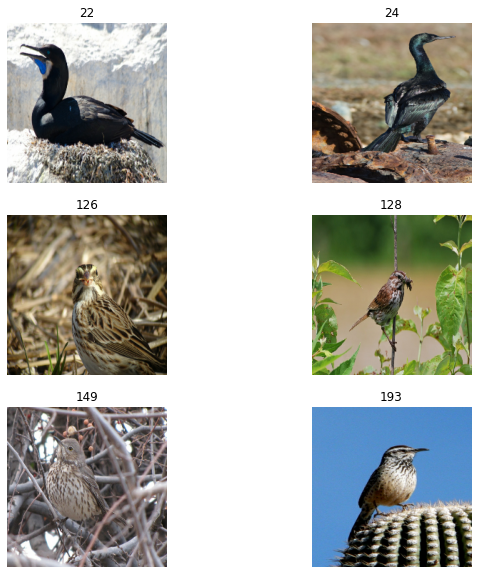

In [96]:
visualize_subplot(list(dict_imagenes_interes.values()), [str(x) for x in dict_imagenes_interes.keys()], (3, 2), (10, 10),)

Por último, se comprueba el rendimiento del regresor partiendo de la noción del modelo base en el que se obtuvo la misma métrica de pérdida. Las imágenes a continuación validan que nuevamente las predicciones realizadas detectan la parte central de los pájaros aunque de una forma bastante holgada.

In [100]:
for X_batch, y_batch in test_dataset.take(1):
    break
np.random.seed(1)
random_sample = np.random.choice(len(X_batch), 9)
X_img = X_batch.numpy()[random_sample]
y_labels = np.where(y_batch['label'].numpy() == True)[1][random_sample]
y_bboxs = y_batch['bbox'].numpy()[random_sample]
y_pred = best_model.predict(X_img)
y_pred_labels = y_pred[0].argmax(axis=1)
y_pred_bboxs = y_pred[1]

In [101]:
imgs = []
for img, bbox, pred_bbox in zip(X_img, y_bboxs, y_pred_bboxs):
    new_img = cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (1, 0, 0), 3)
    new_img = cv2.rectangle(img, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 0, 1), 3)
    imgs.append(new_img)

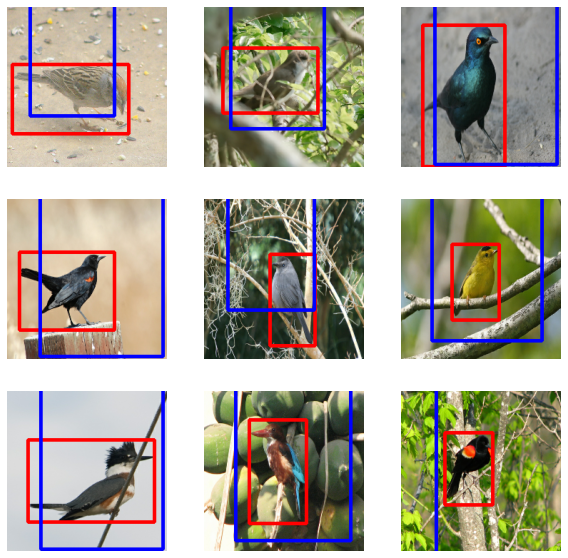

In [102]:
visualize_subplot(imgs, ["" for _ in range(len(imgs))], (3, 3), (10, 10),)

## Conclusiones
1. Infraestructura de acceso libre como lo es Colab, provee herramientas computacionales que permiten acelerar los tiempos de entrenamiento de modelos complejos gracias a procesadores como GPUs y TPUs. No obstante, debido a que organizaciones como Google prestan estos servicios de forma limitada, no es factible utilizarlas en proyectos de gran escala dado que los resultados intermedios se pierden de forma periodica a causa del reinicio del entorno de ejecución.
2. El *transfer learning* permite utilizar modelos preentrados que cuentan con la capacidad de extraer características en otros contextos. Así pues, al utilizar la red de InceptionV3 en el caso en cuestión, se obtuvo un desempeño aceptable del clasificador con base en las características que esta red pudo extraer de las imágenes de aves. Cabe mencionar que se amerita un rendimiento aceptable por parte del clasificador ya que se cuenta con 200 especies de aves y a pesar de esta alta variablidad alcanza una exactitud aproximada del 50%.
3. Si bien la extracción de características que posibilita una red preentrada es de gran utilidad en el caso de un clasificador, a la hora de predecir *bounding boxes* esto puede no ser de gran utilidad ya que se pierde la noción de la posición en la que se detecta cierta cualidad en la imagen. Es por esto que se intuye que en ninguno de los casos el regreso logra deteminar de forma concreta la ubicación de los pájaros.